# A few MNIST experiements with TensorFlow

First, get the data:

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot
from IPython import display

%matplotlib inline

In [3]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("./data/", one_hot=True)


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [4]:
def plotImages(images, imagesToShow = 10):
    #plot.rcParams["figure.figsize"] = 10, 10
    imgs = images[np.random.randint(images.shape[0], size=imagesToShow)]
    plot.imshow(np.hstack([(1.0 - i).reshape((28, 28)) for i in imgs]), cmap="gray")
    #display.display(plot.gcf())

Examples of images from training set:

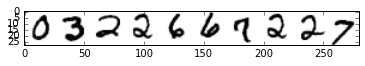

In [5]:
plotImages(mnist.train.images)

Define layer types:

In [31]:
image_size = 28
label_size = 10

# Features and labels
def inputs():
    features = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1], name="features")
    labels = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
    return features, labels

# Cross-entropy loss
def loss(probs, labels):
    return tf.reduce_mean(-tf.reduce_sum(labels * tf.log(probs), reduction_indices=[1]),
                          name="loss")

# Outputs (probabilities)
def probs(logits):
    return tf.nn.softmax(logits)

# Fully-connected layer
def fc_layer(x, size, name):
    # Flatten dims for the fully-connected layer.
    x_flat = tf.reshape(x, [-1, x.get_shape()[1:].num_elements()])
    shape = [x_flat.get_shape()[1].value, size]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name + "_W")
    b = tf.Variable(tf.constant(0.01, shape=[shape[1]]), name=name + "_b")
    return tf.matmul(x_flat, W) + b

# FC layer with ReLU
def fc_relu_layer(x, size, name):
    return tf.nn.relu(fc_layer(x, size, name))

def conv2d_relu_layer(x, kSize, mapCount=1, stride=1, name=''):
    # assuming x is already a 4D tensor
    shape = [kSize, kSize, x.get_shape()[3].value, mapCount]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name + "_W")
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME', name=name + '_conv')
    return tf.nn.relu(conv)
    

## Network topologies

### Simple, one-hidden layer net:

In [23]:
def simpleNet(features):
    h1_size = 200
    h1 = fc_relu_layer(features, h1_size, "h1")
    return h1

### Convolutional net:

In [24]:
def convNet_01(features):
    c1 = conv2d_relu_layer(features, 5, 32, name='c1')
    return c1

Build the graph:

In [32]:
g = tf.Graph()
with g.as_default():
    features, labels = inputs()
    
    #net1 = simpleNet(features)
    net1 = convNet_01(features)
    
    logits = fc_layer(net1, label_size, "logits")
    probs = probs(logits)
    loss = loss(probs, labels)
    
    tf.scalar_summary(loss.op.name, loss)
    
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        summary_writer = tf.train.SummaryWriter("/data/tf/log", sess.graph)
        summary_op = tf.merge_all_summaries()
        
        batch_size = 64
        epoch_size =  mnist.train.num_examples / batch_size
        num_epochs = 1
        for i in range(0, num_epochs * epoch_size):
            f, l = mnist.train.next_batch(64)
            sess.run(train_step, feed_dict={features: f.reshape(batch_size, image_size, image_size, 1), labels: l})

        correct_preds = tf.equal(tf.argmax(probs, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

        print sess.run(accuracy, feed_dict={
                features: mnist.test.images.reshape(mnist.test.num_examples, image_size, image_size, 1),
                labels: mnist.test.labels})

        summary_str = sess.run(summary_op, feed_dict={
                features: mnist.test.images.reshape(mnist.test.num_examples, image_size, image_size, 1),
                labels: mnist.test.labels})
        summary_writer.add_summary(summary_str, 1)
        
        

0.9717
